In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("labor_predictions_log.csv")

In [3]:
df_clean = df.dropna(subset=["Distance", "Labor_Hours"])

In [4]:
df_clean.describe(include="all")

,Name,Size_sqft,Coats,Labor_Hours,Distance,Concurrent_Job,Synthetic
count,31,31.000000,31.000000,31.000000,31.000000,31.000000,31.0
unique,31,NaN,NaN,NaN,NaN,NaN,NaN
top,Coppermine,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8847.580645,1.774194,28.588710,47.274194,0.741935,0.0
std,NaN,2703.140307,0.425024,10.023836,29.478195,0.444803,0.0
min,NaN,6100.000000,1.000000,10.750000,13.000000,0.000000,0.0
25%,NaN,7090.000000,2.000000,22.750000,25.000000,0.500000,0.0
50%,NaN,7900.000000,2.000000,27.250000,36.000000,1.000000,0.0
75%,NaN,10100.000000,2.000000,34.250000,62.000000,1.000000,0.0


In [5]:
df_clean[df_clean["Distance"] > 200]

,Name,Size_sqft,Coats,Labor_Hours,Distance,Concurrent_Job,Synthetic


In [6]:
df_clean.groupby("Coats")["Labor_Hours"].describe()

,count,mean,std,min,25%,50%,75%,max
Coats,,,,,,,,
1.0,7.0,19.285714,7.025888,10.75,15.625,18.000,21.000,33.0
2.0,24.0,31.302083,9.173739,17.50,24.500,28.625,36.125,57.0


In [7]:
df_clean.groupby("Concurrent_Job")["Labor_Hours"].describe()

,count,mean,std,min,25%,50%,75%,max
Concurrent_Job,,,,,,,,
0.0,8.0,28.375000,7.232121,16.25,25.25,28.375,34.50,36.5
1.0,23.0,28.663043,10.970417,10.75,22.75,26.500,33.75,57.0


In [8]:
quartiles = df_clean["Distance"].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
quartiles

array([ 13.,  25.,  36.,  62., 107.])

In [9]:
labels = [f"{int(quartiles[i])}–{int(quartiles[i+1])}" for i in range(len(quartiles)-1)]

In [10]:
df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)

C:\Users\mipo\AppData\Local\Temp\ipykernel_34748\1888029933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)


In [11]:
labor_by_bracket = df_clean.groupby("Distance_Bracket")["Labor_Hours"].mean()
print(labor_by_bracket)

Distance_Bracket
13–25     23.055556
25–36     26.833333
36–62     30.000000
62–107    35.906250
Name: Labor_Hours, dtype: float64


C:\Users\mipo\AppData\Local\Temp\ipykernel_34748\301263866.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labor_by_bracket = df_clean.groupby("Distance_Bracket")["Labor_Hours"].mean()


In [12]:
pivot = df_clean.pivot_table(values="Labor_Hours",
                       index="Coats",
                       columns="Distance_Bracket",
                       aggfunc="mean")
print(pivot)

Distance_Bracket      13–25      25–36    36–62    62–107
Coats                                                    
1.0               19.000000  20.583333  16.2500       NaN
2.0               25.083333  29.958333  33.4375  35.90625


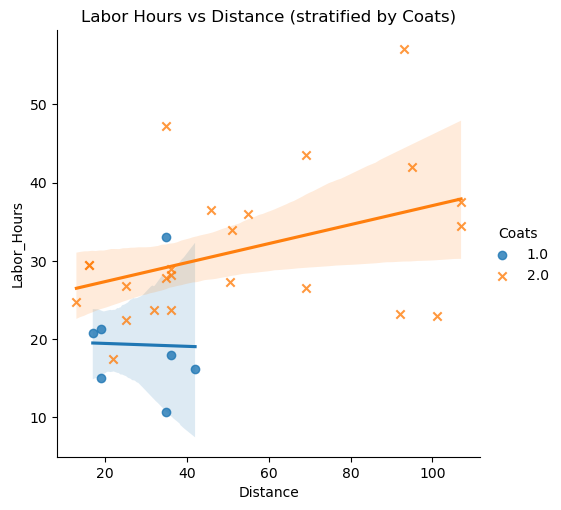

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(data=df_clean, x="Distance", y="Labor_Hours", hue="Coats", markers=["o", "x"])
plt.title("Labor Hours vs Distance (stratified by Coats)")
plt.show()

In [14]:
df_clean.groupby("Synthetic")["Labor_Hours"].describe()

,count,mean,std,min,25%,50%,75%,max
Synthetic,,,,,,,,
0.0,31.0,28.58871,10.023836,10.75,22.75,27.25,34.25,57.0


In [15]:
df_clean = df.dropna(subset=["Distance", "Labor_Hours", "Coats", "Concurrent_Job"])

In [16]:
# First compute quartiles and labels
quartiles = df_clean["Distance"].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
labels = [f"{int(quartiles[i])}–{int(quartiles[i+1])}" for i in range(len(quartiles)-1)]

# Add bin column to df_clean
df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)

# Now encode everything including the bracket
df_encoded = pd.get_dummies(df_clean, columns=["Distance_Bracket", "Coats", "Concurrent_Job", "Name"], drop_first=True)

C:\Users\mipo\AppData\Local\Temp\ipykernel_34748\397517718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Distance_Bracket"] = pd.cut(df_clean["Distance"], bins=quartiles, labels=labels, include_lowest=True)


In [17]:
X = df_encoded.drop(columns=["Labor_Hours", "Distance"])
y = df_encoded["Labor_Hours"]

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error

predictions = model.predict(X)
print("R²:", r2_score(y, predictions))
print("MAE:", mean_absolute_error(y, predictions))

R²: 1.0
MAE: 2.337914807984846e-14
